<a href="https://colab.research.google.com/github/s83512266/Tibame_AI_111-2_group2_project/blob/main/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt # seaborn
from PIL import Image

import os # file path
from glob import glob # search files
from tqdm.auto import tqdm # progress bar

import tensorflow as tf
from tensorflow.keras import layers, models, utils

from sklearn.model_selection import train_test_split

**Read one image**

In [ ]:
IMG_SIZE = 256 # 256 128 64

all_class = ['Monstera_Deliciosa', 'new_leaf', 'Others']
class_map = {cls: i for i, cls in enumerate(all_class)} 
#  'Monstera_Deliciosa':0, 'new_leaf': 1, 'Others':2
class_map

{'Monstera_Deliciosa': 0, 'new_leaf': 1, 'Others': 2}

In [ ]:
MD_path = glob("/content/drive/MyDrive/圖片/(a)龜背芋正常 (含幼葉、成熟葉)/train/*.jpg")
NL_path = glob('/content/drive/MyDrive/圖片/(b)新葉/train/*.jpg')
Others_path = glob("/content/drive/MyDrive/圖片/(i)非龜背芋種/train/*.jpg")

img_paths = MD_path + NL_path + Others_path


In [ ]:
# number of images
len(img_paths)

551

/content/drive/MyDrive/圖片/(b)新葉/train/20.jpg
(844, 844, 3)


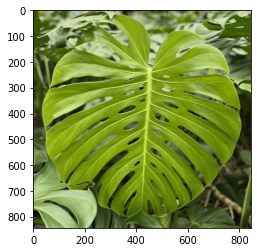

In [ ]:
# show image
path = img_paths[300]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(path)
print(img.shape)
plt.imshow(img)
plt.show()

((844, 844, 3), (256, 256, 3))

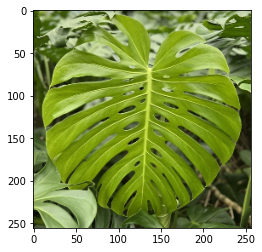

In [ ]:
# Resize  img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Extract img class
# os.sep: /
print(path)
cls = path.split(os.sep)[-3]
print(cls)

/content/drive/MyDrive/圖片/(b)新葉/train/20.jpg
(b)新葉


In [ ]:
# Get file class index for train

# for Monstera_Deliciosa class
if cls == '(a)龜背芋正常 (含幼葉、成熟葉)':
    cls_idx = class_map["Monstera_Deliciosa"]
    print(cls_idx)
# for new_leaf class
elif cls == '(b)新葉':
    cls_idx = class_map["new_leaf"]
    print(cls_idx)
# for others class
else:
    cls_idx = class_map["Others"]
    print(cls_idx)

1


**Read all images**

In [ ]:
def read_data(paths):
    data_count = len(paths)
    x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3)) # model input
    y = np.zeros((data_count, )) # answer

    for i, path in enumerate(tqdm(paths)):
        # read image
        img = cv2.imread(path) # (H, W, 3)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # resize
        # Normalization
        img = img / 255. # 0~255 -> 0~1

        # read class index
        cls = path.split(os.sep)[-3]
        
        # for Monstera_Deliciosa class
        if cls == '(a)龜背芋正常 (含幼葉、成熟葉)':
            cls_idx = class_map["Monstera_Deliciosa"]
        # for new_leaf class
        elif cls == '(b)新葉':
            cls_idx = class_map["new_leaf"]
        # for others class
        else:
            cls_idx = class_map["Others"]
        
        x[i] = img
        y[i] = cls_idx
    return x, y


In [ ]:
x, y = read_data(img_paths)

In [ ]:
x.shape, y.shape

((551, 256, 256, 3), (551,))

In [ ]:
from sklearn.model_selection import train_test_split
# split train and test dataset
# 90%x, 10%x, 90%y, 10%y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((495, 256, 256, 3), (56, 256, 256, 3), (495,), (56,))

In [ ]:
# label count
print(all_class)
# train
unique_classes, counts = np.unique(y_train, return_counts=True)
print(unique_classes, counts)

# test
unique_classes, counts = np.unique(y_test, return_counts=True)
print(unique_classes, counts)

['Monstera_Deliciosa', 'new_leaf', 'Others']
[0. 1. 2.] [252  71 172]
[0. 1. 2.] [29  8 19]


In [ ]:
# one-hot encoding
y_train = utils.to_categorical(y_train, num_classes=len(class_map))
y_test = utils.to_categorical(y_test, num_classes=len(class_map))

In [ ]:
y_train.shape, y_test.shape

((495, 3), (56, 3))

**Build model**

In [ ]:
# Conv, BN, Activation
class ConvBN(layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.conv = layers.Conv2D(filters, kernel_size, padding="same")
        self.normalization = layers.BatchNormalization()
        self.act = layers.LeakyReLU()

    def call(self, x):
        x = self.conv(x)
        x = self.normalization(x)
        return self.act(x)

In [ ]:
class MyModel(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.encoder = models.Sequential([
            ConvBN(64, 3),
            ConvBN(64, 3),
            layers.MaxPool2D(2),
            ConvBN(128, 3),
            ConvBN(128, 3),
            layers.MaxPool2D(2),
            ConvBN(256, 3),
            ConvBN(256, 3),
            layers.MaxPool2D(2),
        ])
        # self.flatten = layers.Flatten()
        self.flatten = layers.GlobalAveragePooling2D()
        self.classifier = models.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(3, activation='softmax')               
        ])

    def call(self, x):
        print("Start call")
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


model = MyModel()
model.build((1, IMG_SIZE, IMG_SIZE, 3)) # (BS, H, W, C)

Start call


In [ ]:
model.encoder.summary()
model.classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn_6 (ConvBN)          (1, 256, 256, 64)         2048      
                                                                 
 conv_bn_7 (ConvBN)          (1, 256, 256, 64)         37184     
                                                                 
 max_pooling2d_3 (MaxPooling  (1, 128, 128, 64)        0         
 2D)                                                             
                                                                 
 conv_bn_8 (ConvBN)          (1, 128, 128, 128)        74368     
                                                                 
 conv_bn_9 (ConvBN)          (1, 128, 128, 128)        148096    
                                                                 
 max_pooling2d_4 (MaxPooling  (1, 64, 64, 128)         0         
 2D)                                                  

**Training model**

In [ ]:
# y_train是one-hot encoding，不能使用SparseCategoricalCrossentropy()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    # ModelCheckpoint("best.h5", save_best_only=True),
    # subclassed models不能使用ModelCheckpoint存模型
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [ ]:
logs = model.fit(x_train, y_train,
          batch_size=4,
          epochs=50,
          validation_split=0.1,
          callbacks=callbacks
    )

Epoch 1/50
Start call
Start call
112/112 [==============================] - 19s 79ms/step - loss: 1.0362 - accuracy: 0.4652 - val_loss: 1.7083 - val_accuracy: 0.0800
Epoch 2/50
112/112 [==============================] - 8s 68ms/step - loss: 0.9233 - accuracy: 0.5416 - val_loss: 1.5369 - val_accuracy: 0.0800
Epoch 3/50
112/112 [==============================] - 8s 69ms/step - loss: 0.8789 - accuracy: 0.5618 - val_loss: 2.6146 - val_accuracy: 0.0800
Epoch 4/50
112/112 [==============================] - 8s 70ms/step - loss: 0.8683 - accuracy: 0.5888 - val_loss: 0.9382 - val_accuracy: 0.6000
Epoch 5/50
112/112 [==============================] - 8s 70ms/step - loss: 0.8432 - accuracy: 0.5888 - val_loss: 2.8648 - val_accuracy: 0.1400
Epoch 6/50
112/112 [==============================] - 8s 71ms/step - loss: 0.8207 - accuracy: 0.6247 - val_loss: 1.0041 - val_accuracy: 0.6400
Epoch 7/50
112/112 [==============================] - 8s 71ms/step - loss: 0.8228 - accuracy: 0.5910 - val_loss: 0.8019

**Training log**

In [ ]:
history = logs.history
min_loss_epoch = np.argmin(history['val_loss'])
print('min_loss_epoch: ', min_loss_epoch+1)
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

min_loss_epoch:  15
val loss  0.6361057758331299
val acc 0.7599999904632568


Text(0.5, 1.0, 'accuracy')

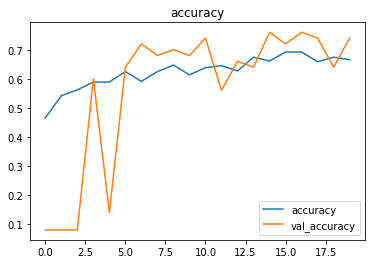

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

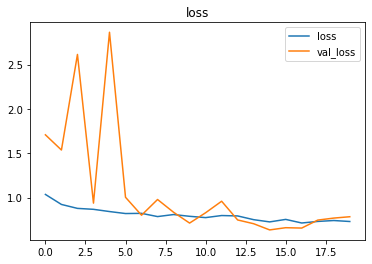

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

**Evaluate**

In [ ]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 6s 2s/step - loss: 0.6064 - accuracy: 0.7500


[0.6064239740371704, 0.75]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.argmax(y_test, axis=-1) # [0, 1, 2, ...]

prediction = model.predict(x_test)
y_pred = np.argmax(prediction, axis=-1) # [0, 1, 2, ...]

print(y_true.shape, y_pred.shape)

Start call
2/2 [==============================] - 0s 179ms/step
(56,) (56,)


In [ ]:
# classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.86      0.78        29
           1       0.78      0.88      0.82         8
           2       0.83      0.53      0.65        19

    accuracy                           0.75        56
   macro avg       0.78      0.75      0.75        56
weighted avg       0.76      0.75      0.74        56



In [ ]:
import pandas as pd
# Confusion matrix:
#   row: Ground truth
#   column: predict
mat = confusion_matrix(y_true, y_pred)
pd.DataFrame(mat,
      columns=["{}(predict)".format(all_class[i]) for i in range(3)],
      index=["{}(true)".format(all_class[i]) for i in range(3)])

,Monstera_Deliciosa(predict),new_leaf(predict),Others(predict)
Monstera_Deliciosa(true),25,2,2
new_leaf(true),1,7,0
Others(true),9,0,10


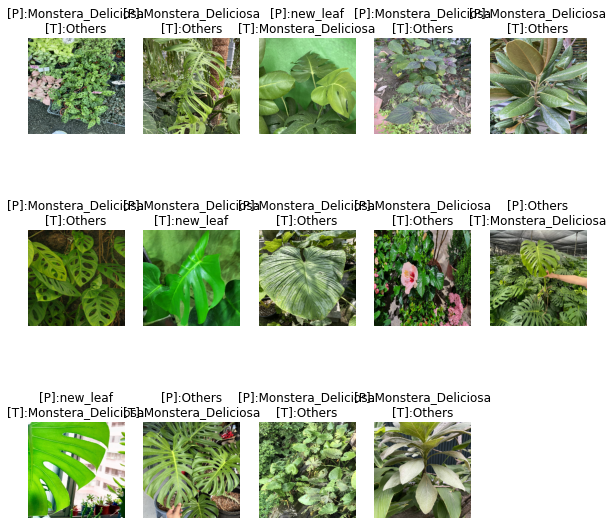

In [ ]:
import IPython.display as dp
from google.colab.patches import cv2_imshow
plt.figure(figsize=(10, 10))

idx = np.nonzero(y_pred != y_true)[0]

false_pre = y_pred[idx]
false_true = y_true[idx]
false_img = x_test[idx]

width = 5
height = len(idx) // width + 1

for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    title = "[P]:{}\n[T]:{}".format(all_class[false_pre[i]], all_class[false_true[i]])
    plt.title(title)
    plt.axis("off")
    for j in range(len(false_img)):
        false_img[j]
    plt.imshow(false_img[i][:, :, ::-1])

**Save model**

In [ ]:
# 1. save whole model and weights
# model.save('/content/drive/MyDrive/my_model.h5')
# 2. save and load weights only
model.save_weights('/content/drive/MyDrive/CLF_model_weights.h5')


**Load model**

In [ ]:
# 1. load whole model and weights
# model2 = models.load_model('my_model.h5')
# 2. Rebuild model before load weights !
# model2 = MyModel()
# model2.load_weights('CLF_model_weights.h5')

**Predict image**

輸入一個網址https://succuland.com.tw/wp-content/uploads/2018/06/wedo-%E7%A7%8B%E9%BA%97-%E5%85%A7%E5%AE%B9%E5%9C%9602.jpg


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


1/1 [==============================] - 0s 18ms/step
Monstera_Deliciosa 的機率: 0.81058353
new_leaf 的機率: 0.088212356
Others 的機率: 0.101204224
答案是: Monstera_Deliciosa


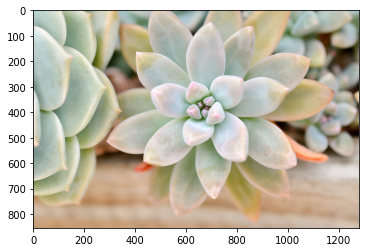

In [ ]:
import requests

url = input("輸入一個網址")
h = {
    "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"
}

response = requests.get(url, stream=True, verify=False, headers=h)
img = Image.open(response.raw)
img_r = img.convert("RGB").resize((256, 256))
img_r = np.array(img_r).reshape(1, 256, 256, 3) / 255.0
proba = model.predict(img_r)[0]
for t, p in zip(all_class, proba):
    print(t, "的機率:", p)
ans = all_class[proba.argmax(axis=-1)]
print("答案是:", ans)
plt.imshow(img)